**Research Question:**

Causal effect of Pm2.5 concentration on COPD (chronic obstructive pulmonary disease)

*resources:*

https://towardsdatascience.com/causal-inference-with-continuous-treatments-5ff691869a65 

difference in outcomes - lab 8

https://www.practicalpropensityscore.com/continuous.html




In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# COPY THIS
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/data102')

Mounted at /content/drive


In [3]:
!pip install sodapy
from sodapy import Socrata
from scripts.state_agg import get_cdc_data, agg_county_weighted_mean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#preparing pm25 dataset

pm25_2011 = agg_county_weighted_mean(get_cdc_data("01JUL2011", ozone=False)).rename(columns={"01JUL2011": "pm25"})
pm25_2011["YEAR"] = np.full(len(pm25_2011),"2011")
pm25_2012 = agg_county_weighted_mean(get_cdc_data("01JUL2012", ozone=False)).rename(columns={"01JUL2012": "pm25"})
pm25_2012["YEAR"] = np.full(len(pm25_2011),"2012")
pm25_2013 = agg_county_weighted_mean(get_cdc_data("01JUL2013", ozone=False)).rename(columns={"01JUL2013": "pm25"})
pm25_2013["YEAR"] = np.full(len(pm25_2011),"2013")
pm25_2014 = agg_county_weighted_mean(get_cdc_data("01JUL2014", ozone=False)).rename(columns={"01JUL2014": "pm25"})
pm25_2014["YEAR"] = np.full(len(pm25_2011),"2014")
pm25_by_state = pd.concat([pm25_2011, pm25_2012, pm25_2013, pm25_2014])
pm25_by_state.head()

100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


,pm25,state,abbrev,YEAR
0,15.752966,Alabama,AL,2011
2,9.017771,Arizona,AZ,2011
3,15.002441,Arkansas,AR,2011
4,10.737480,California,CA,2011
6,7.272776,Colorado,CO,2011


## Preparing copd and smoking datasets

In [5]:
cdi = pd.read_csv('data/cdi.csv')

<ipython-input-5-72ff7dc6ab96>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cdi = pd.read_csv('data/cdi.csv')


In [6]:
copd = cdi[(cdi['Topic'] == "Chronic Obstructive Pulmonary Disease") &
           (cdi['Question'] == 'Prevalence of chronic obstructive pulmonary disease among adults >= 18') &
           (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]
copd = copd[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "COPD Prevalence"})

In [7]:
smoking = cdi[(cdi["Topic"] == 'Tobacco') & (cdi["Question"] == "Current smoking among adults aged >= 18 years")&
              (cdi["YearStart"].isin([2011,2012,2013,2014])) &
           (cdi["StratificationCategory1"] == 'Overall')&
           (cdi["DataValueType"] == 'Age-adjusted Prevalence')]
smoking = smoking[['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueAlt', 
             'LowConfidenceLimit', 'HighConfidenceLimit']].rename(columns={"DataValueAlt": "Smoking Prevalence"})

In [8]:
copd["YearStart"] = copd["YearStart"].astype(str)
smoking["YearStart"] = smoking["YearStart"].astype(str)
pm25_by_state["YEAR"] = pm25_by_state["YEAR"].astype(str)

## Merging CDI and PM2.5 datasets

In [9]:
data = pm25_by_state.merge(smoking, left_on=["YEAR", "abbrev"], right_on=['YearStart', 'LocationAbbr'], how='inner')
data = data[["YEAR", "abbrev", "pm25", "Smoking Prevalence"]]
data

,YEAR,abbrev,pm25,Smoking Prevalence
0,2011,AL,15.752966,24.6
1,2011,AZ,9.017771,19.3
2,2011,AR,15.002441,27.3
3,2011,CA,10.737480,13.6
4,2011,CO,7.272776,18.1
...,...,...,...,...
191,2014,VA,10.583199,19.8
192,2014,WA,7.149102,15.6
193,2014,WV,16.300198,28.2
194,2014,WI,4.695647,17.9


In [10]:
df = copd.merge(data, left_on=["LocationAbbr", "YearStart"], right_on=["abbrev", "YEAR"], how='inner')
#df = df[['YEAR', 'abbrev', 'COPD Prevalence', 'pm25']]
df.head()

,YearStart,LocationAbbr,LocationDesc,COPD Prevalence,LowConfidenceLimit,HighConfidenceLimit,YEAR,abbrev,pm25,Smoking Prevalence
0,2011,AL,Alabama,9.3,8.4,10.2,2011,AL,15.752966,24.6
1,2013,AL,Alabama,9.9,8.9,11.0,2013,AL,10.931882,22.1
2,2012,AL,Alabama,9.3,8.5,10.2,2012,AL,21.661216,24.4
3,2014,AL,Alabama,9.7,8.9,10.5,2014,AL,22.966910,21.7
4,2012,AR,Arkansas,8.2,7.4,9.2,2012,AR,13.707120,25.7


In [11]:
#data_filtered = df[df["YEAR"] + 5 == df["YearStart"]]
#data_filtered

In [12]:
data_filtered = df[["YEAR", "abbrev", "pm25", "Smoking Prevalence", "COPD Prevalence"]]
data_filtered = data_filtered.rename(columns={'Smoking Prevalence':"smoking_prevalence", "COPD Prevalence": "copd_prevalence"})

In [13]:
data_filtered.sort_values(by='pm25')

,YEAR,abbrev,pm25,smoking_prevalence,copd_prevalence
104,2014,ND,2.135186,20.6,4.4
87,2014,MN,3.362189,16.6,4.1
169,2014,UT,4.434712,9.5,3.8
149,2014,RI,4.688082,17.1,5.2
184,2014,WI,4.695647,17.9,4.7
...,...,...,...,...,...
39,2014,GA,22.266333,17.4,7.3
3,2014,AL,22.966910,21.7,9.7
5,2014,AR,23.433149,25.4,8.2
36,2012,GA,24.047783,20.2,7.0


## Outcome regression with IPW

In [14]:
def conditional_densities(data, use_confounders=True):
    formula = "pm25 ~ 1"
    if use_confounders:
        formula += "+ smoking_prevalence"
    model = sm.formula.ols(formula, data=data).fit()
    density = stats.norm(
        loc=model.fittedvalues,
        scale=model.resid.std(),
    )
    densities = density.pdf(data["pm25"])
    densities = pd.Series(densities, index=model.fittedvalues.index)
    return densities

In [15]:
denominator = conditional_densities(data_filtered, use_confounders=True)
numerator = conditional_densities(data_filtered, use_confounders=False)
generalized_ipw = numerator / denominator

In [16]:
generalized_ipw

0      0.651466
1      0.941496
2      0.508559
3      1.077887
4      0.760244
         ...   
191    0.489361
192    1.376794
193    1.083254
194    0.789626
195    0.932427
Length: 196, dtype: float64

In [25]:
model_copd = sm.formula.wls(
    "copd_prevalence ~ 1 + pm25 ",
    data=data_filtered,
    weights=generalized_ipw,
).fit()


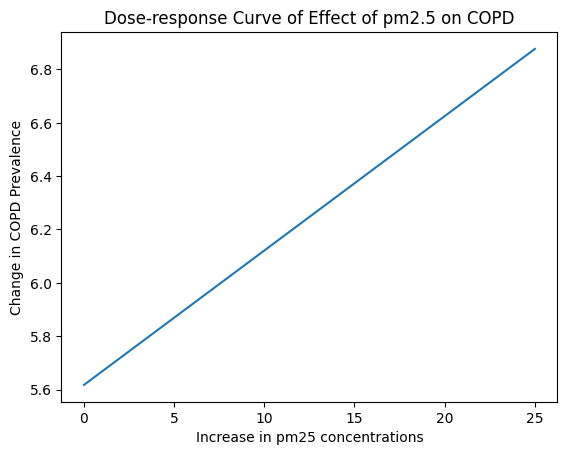

In [26]:
concentration = list(range(26))
concentration = pd.DataFrame(
    data={"pm25": concentration},
    index=concentration)
response = model_copd.predict(concentration)
ax = response.plot(
    kind="line",
    xlabel="Increase in pm25 concentrations",
    ylabel="Change in COPD Prevalence",
    title="Dose-response Curve of Effect of pm2.5 on COPD"
)

In [27]:
model_copd.conf_int()

,0,1
Intercept,5.069292,6.165152
pm25,0.005220,0.095568


In [28]:
model_copd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        copd_prevalence   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     4.841
Date:                Mon, 08 May 2023   Prob (F-statistic):             0.0290
Time:                        04:56:05   Log-Likelihood:                -361.28
No. Observations:                 196   AIC:                             726.6
Df Residuals:                     194   BIC:                             733.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6172      0.278     20.219      0.000       5.069       6.165
pm25           0.0504      0.023      2.200      0.029       0.005       0.096
==============================================================================
Omnibus:                       30.585   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.239
Skew:                           0.643   Prob(JB):                     2.29e-18
Kurtosis:                       5.880   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""